In [1]:
using CairoMakie
using FourierFlows
using JLD2
using Printf
using StatsBase
include("../AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [2]:
function find_max_u(directory)
    params = read_swqg_params(directory, "swqg")
    nx, Lx = get_grid_size(directory, "swqg")
    grid = TwoDGrid(; nx, Lx)
    
    filename_func(idx) = @sprintf("%s/swqg.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("swqg.", file)])-1
    file_idx = 1
    ψh = zeros(Complex{Float64}, grid.nkr, grid.nl, 2)

    umax = 0
    max_index = 0
    max_time = 0
    cur_idx = 2
    for j=0:num_files
        file = jldopen(filename_func(j))
        for key=keys(file["snapshots/t"])[end-100:10:end]
            t = file["snapshots/t/" * key]
            qh = file["snapshots/sol/" * key]
            @. ψh = -qh/(grid.Krsq + params.Kd2)
            uh =  -grid.l  .* ψh
            vh =   grid.kr .* ψh
            u = irfft(uh, grid.nx)
            v = irfft(vh, grid.nx)
            max_speed = sqrt.(maximum(u.^2 + v.^2))
            if max_speed >= umax
                umax = max_speed
                max_index = cur_idx
                max_time = t
            end
            cur_idx += 1
        end
        close(file)
    end
    return umax, max_index, max_time
end

function compute_avg_diffusion(directory, offset, Nsnapshots)
    t2, _, k2, _ = load_snapshot(directory, Nsnapshots)
    b = 0.0
    for i=1:offset
        t1, _, k1, up = load_snapshot(directory, Nsnapshots - i)
        dt = t2 - t1

        K1 = sqrt.(k1[:,1].^2 + k1[:,2].^2)
        K2 = sqrt.(k2[:,1].^2 + k2[:,2].^2)
        mask = isfinite.(K2) .& isfinite.(K1)
        
        b += sum((K2[mask] - K1[mask]).^2) / sum(2 * K1.^2 * dt)

        t2 = t1
        k2 = k1
    end
    return b / offset
end

function compute_GBM_parameters(directory, Nsnapshots)
    _, _, k0, _ = load_snapshot(directory, 1)
    t0, _, _, _ = load_snapshot(directory, 2)
    t, _, k, _ = load_snapshot(directory, Nsnapshots)

    Δt = t - t0
    K0 = mean(sqrt.(k0[:,1].^2 + k0[:,2].^2))
    K = sqrt.(k[:,1].^2 + k[:,2].^2)
    mean_K = mean(K)
    var_K = var(K)
    
    drift = (log.(mean_K/K0)./(Δt))
    diffusion = (log.(var_K/K0^2 .* exp.(-2*drift.*Δt) .+ 1) ./ (Δt))
    
    return drift, diffusion
end

compute_GBM_parameters (generic function with 1 method)

In [3]:
#predicate = "/scratch/nad9961/swqg/"
predicate = "/scratch/nad9961/twolayer_rays/"
froude_number = []
max_x_froude_number = []
max_xt_froude_number = []
max_ts = []
f0s = []
ωs = []
median_ωs = []
mean_diffusion = []
drift = []
diffusion = []
qs = []
for line=readlines("raytracing-runs-3.txt")
    run_directory = predicate * line
    f0, Cg = read_parameters(run_directory)
    nx, Lx = get_grid_size(run_directory, "swqg")
    grid = TwoDGrid(;nx, Lx)
    Nsnapshots = count_snapshots(run_directory)
    Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
    _, _, k0, _ = load_snapshot(run_directory, 1)
    t, _, k, up = load_snapshot(run_directory, Nsnapshots)
    
    #b = compute_avg_diffusion(run_directory, 1, Nsnapshots)
    K = sqrt.(k[:,1].^2 + k[:,2].^2)
    K0 = sqrt.(k0[:,1].^2 + k0[:,2].^2)
    mask = isfinite.(K)
    mean_K = mean(K[mask])
    var_K = var(K[mask])
    mean_K0 = mean(K0[mask])

    b = log(mean_K / mean_K0)/(3 * t)
    μ = log(mean_K / mean_K0)/(t)
    σ = sqrt(log(var_K / (mean_K0^2*exp(2 * μ * t)) + 1) / t)
    
    t, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
    rms_u = sqrt.(sum(u.^2 + v.^2) * (grid.dx * grid.dy) / grid.Lx/grid.Ly) * (grid.Lx/(2π))^2
    rms_up = sqrt.(sum(up[:,1].^2 + up[:,2].^2)/size(up, 1))
    rms_up = mean(sqrt.(up[:,1].^2 + up[:,2].^2))
    u_max_x = maximum(sqrt.(u.^2 + v.^2))
    #u_max_xt, max_index, max_time = find_max_u(run_directory)
    ω = compute_ω(k, f0, Cg)
    mean_ω = mean(ω[isfinite.(ω)])
    median_ω = median(ω[isfinite.(ω)])
    println(@sprintf("dir: %s, Umax_x: %0.4f, Urms: %0.4f Uprms: %0.4f, Cg: %0.2f, mean ω: %0.1f, Fr: %0.3f, Lx=%0.0fπ", line, u_max_x, rms_u, rms_up, Cg, mean_ω, rms_u/Cg, Lx/π))
    push!(max_x_froude_number, u_max_x / Cg)
    #push!(max_xt_froude_number, u_max_xt / Cg)
    push!(froude_number, rms_u / Cg)
    push!(ωs, mean_ω)
    push!(f0s, f0)
    push!(max_ts, t)
    push!(median_ωs, median_ω)
    push!(qs, q)
    push!(mean_diffusion, b)
    push!(drift, μ)
    push!(diffusion, σ)
end

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/hbsZG/src/JLD2.jl:162


LoadError: SystemError: opening file "/scratch/nad9961/twolayer_rays/1308040/1/packets.000000.jld2": No such file or directory

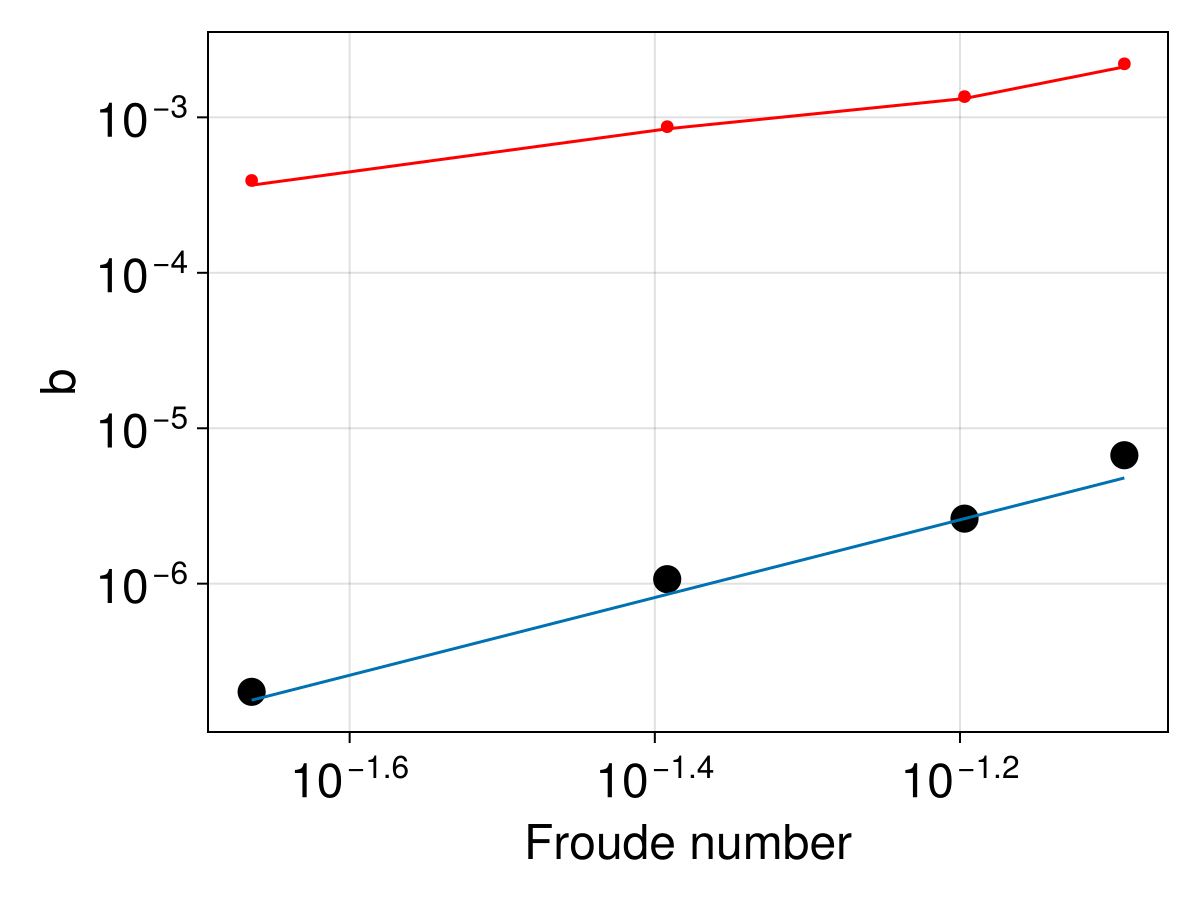

In [23]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="Froude number", ylabel=rich("b")) #title=rich("Median frequency vs Fr", subscript("rms")))
scatter!(ax, froude_number, drift, markersize=20, color=:black)
scatter!(ax, froude_number, diffusion,  color=:red)
lines!(ax, froude_number, sqrt.(2*drift/3), color=:red)
#lines!(ax, froude_number, mean_diffusion[4]/65536 * (froude_number/froude_number[4]).^2)
lines!(ax, froude_number, drift[3] * (froude_number/froude_number[3]).^2.5)
#lines!(ax, froude_number, froude_number.^4, linestyle=:dash, color=:black)
#scatter!(ax, froude_number, ωs./f0s, markersize=12, color=:red)

#save("images/froude_number_vs_median_freq.eps", fig)
fig

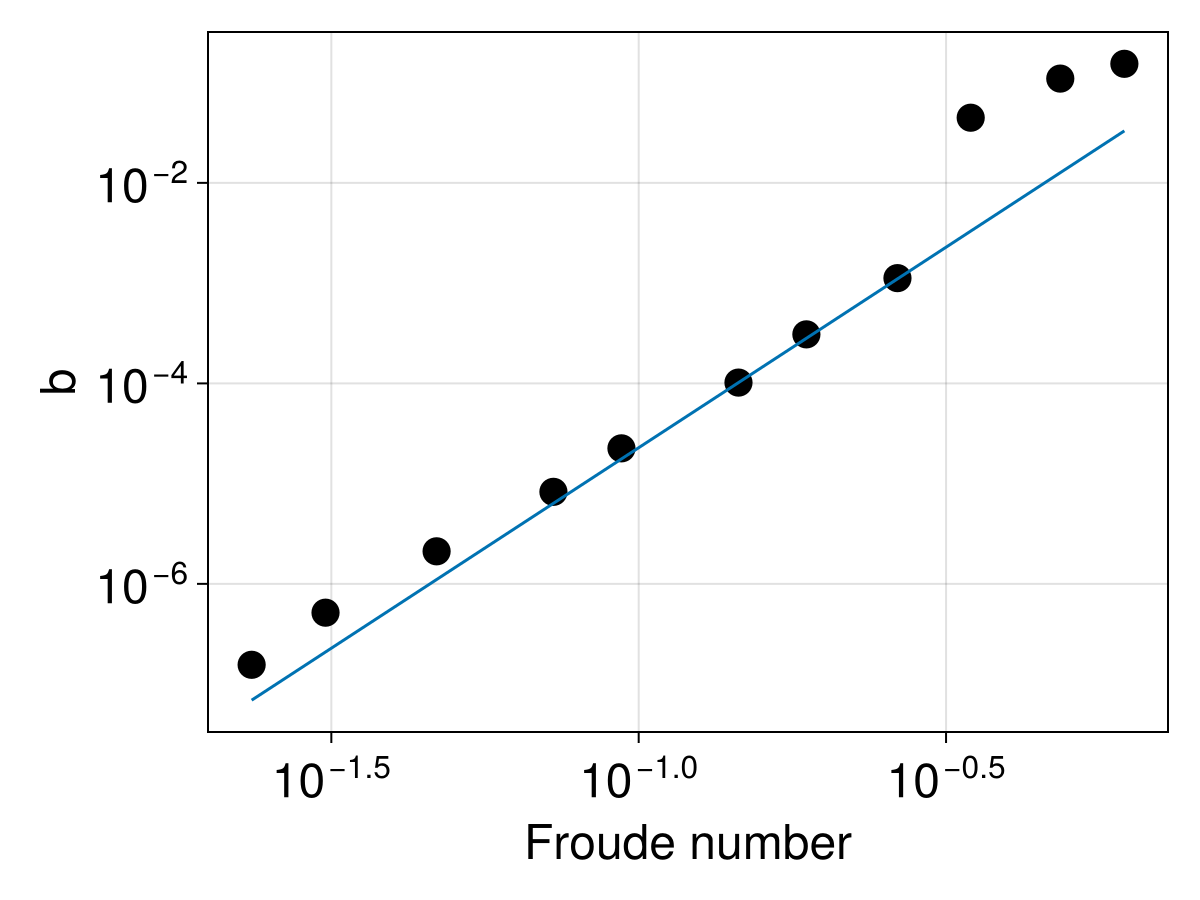

In [85]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="Froude number", ylabel=rich("b")) #title=rich("Median frequency vs Fr", subscript("rms")))
scatter!(ax, froude_number, mean_diffusion, markersize=20, color=:black)
#lines!(ax, froude_number, mean_diffusion[4]/65536 * (froude_number/froude_number[4]).^2)
lines!(ax, froude_number, mean_diffusion[6] * (froude_number/froude_number[6]).^4)
#lines!(ax, froude_number, froude_number.^4, linestyle=:dash, color=:black)
#scatter!(ax, froude_number, ωs./f0s, markersize=12, color=:red)

#save("images/froude_number_vs_median_freq.eps", fig)
fig

In [10]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel=rich("max", subscript("x,t"), "|u| / C",subscript("g")), ylabel=rich("mean ω"), title=rich("Mean frequency vs Fr", subscript("max")))
scatter!(ax, max_froude_number, median_ωs, markersize=12, color=:black)

fig

LoadError: UndefVarError: `max_froude_number` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

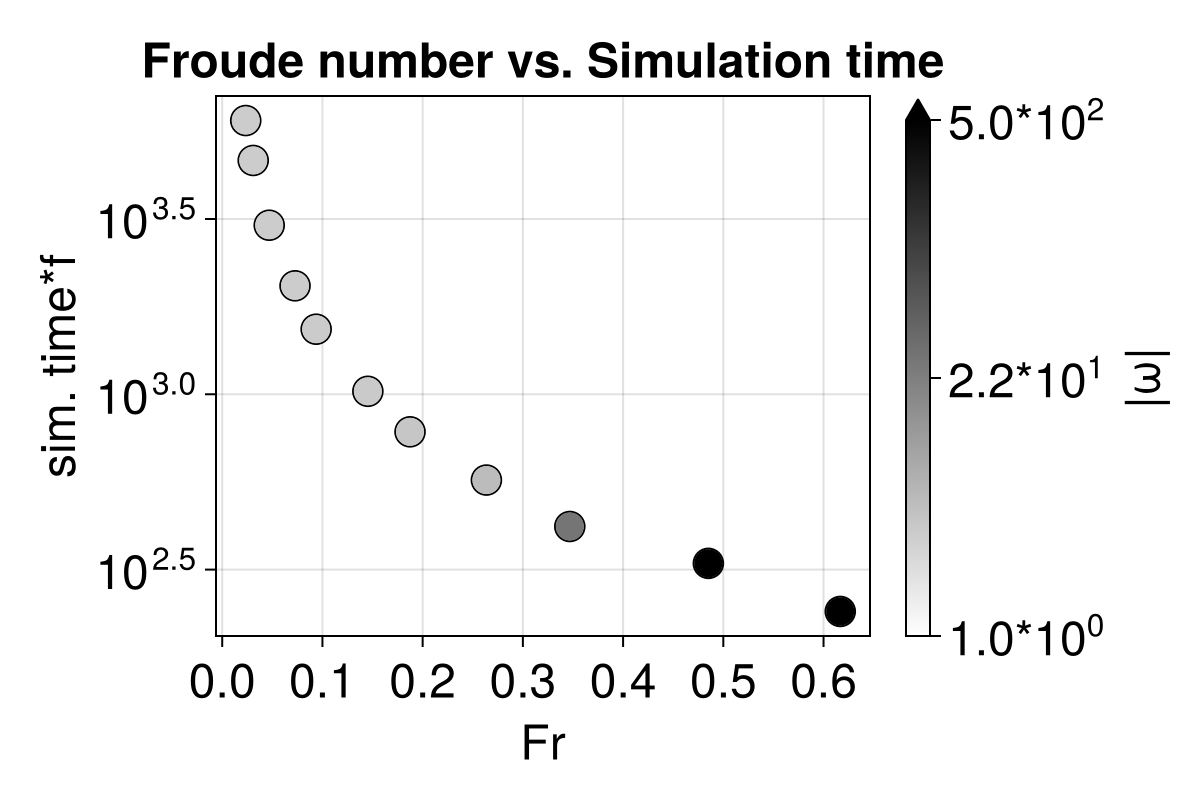

In [4]:
function to_scientific(val)
    power = floor(Int, log10.(val))
    mantissa = val / 10^power
    return rich(@sprintf("%0.1f*10", mantissa), superscript(@sprintf("%d", power)))
end

fig = Figure(size=(600, 400), fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel="Fr", ylabel="sim. time*f", title="Froude number vs. Simulation time")
cutoff = 500
colors = 0.5*(log.(median_ωs./f0s)/log(cutoff)) .+ 0.5
tick_vals = [0.5, 0.75, 1.0]
tick_label_vals = exp.(2*(tick_vals .- 0.5)*log(cutoff))
tick_labels = [to_scientific(label_val) for label_val=tick_label_vals]
scatter!(ax, froude_number, max_ts.*f0s, markersize=21, color=:transparent, strokewidth=1, strokecolor=:black)
sc = scatter!(ax, froude_number, max_ts.*f0s, markersize=20, colorrange=(0.5, 1.0), highclip=:black, colormap=:binary, color=colors)
Colorbar(fig[1,2], sc; label="|ω|", ticks=(tick_vals, tick_labels))

fig

In [107]:
run_directory = "/scratch/nad9961/swqg/3288403/4"
f0, Cg = read_parameters(run_directory)
nx, Lx = get_grid_size(run_directory, "swqg")
grid = TwoDGrid(;nx, Lx)
Nsnapshots = count_snapshots(run_directory)
Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
t, _, k, up = load_snapshot(run_directory, Nsnapshots)
t, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
rms_u = sqrt.(sum(u.^2 + v.^2) * (grid.dx * grid.dy) / grid.Lx/grid.Ly) * (grid.Lx/(2π))^2
ω = compute_ω(k, f0, Cg)
mean_ω = mean(ω[isfinite.(ω)])
median_ω = median(ω[isfinite.(ω)])


Any[]

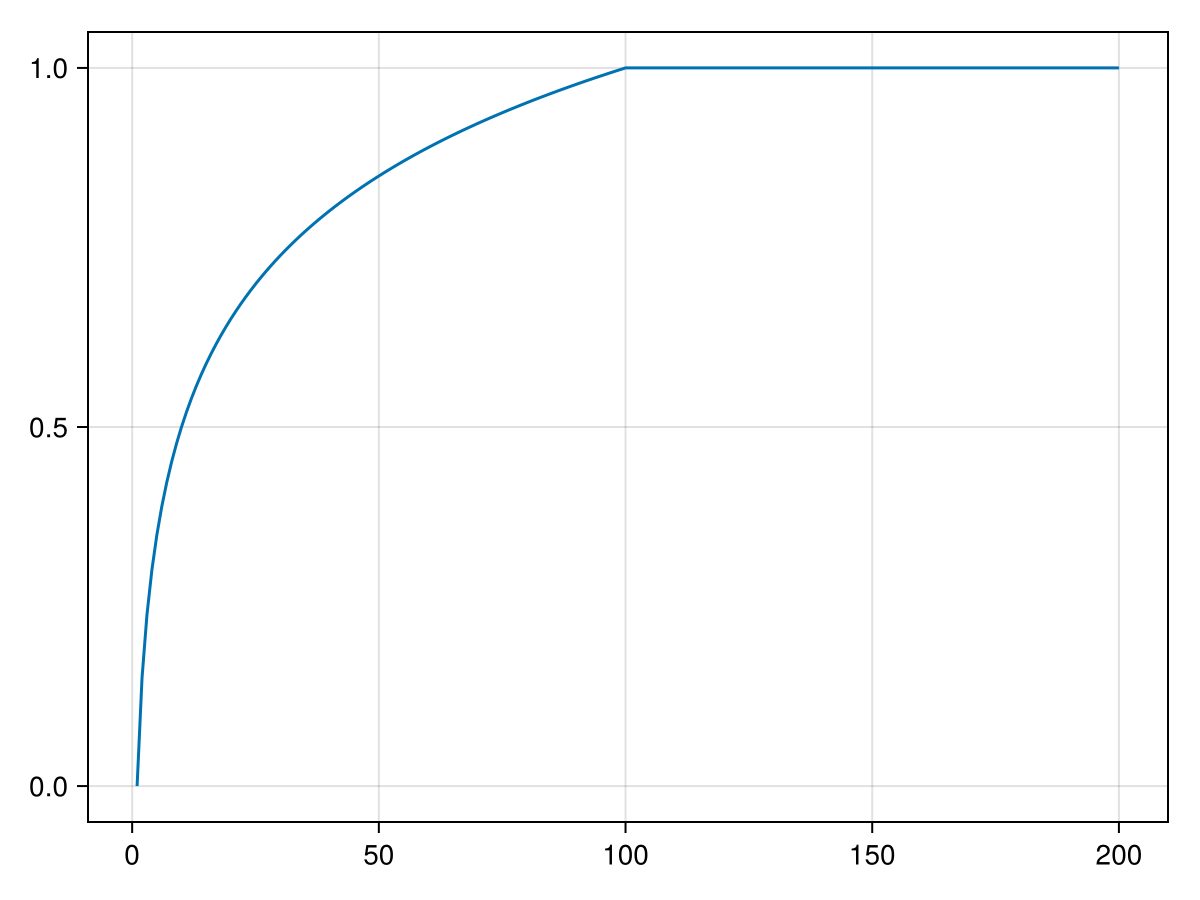

In [45]:
function color_gen(ω, cutoff)
    # If ω = 1: 0
    # If ω >= cutoff: 1
    # Logarithmic inbetween
    return log.(min.(ω, cutoff))/log(cutoff)
end

x = 1:200
cutoff = 100
lines(x, color_gen(x, cutoff))

In [36]:
color_gen(200, 200)

0.84122743555108

In [39]:
min.(1, log.(200/200))

0.0

In [29]:
weird_directory = "/scratch/nad9961/swqg/60202002/7/"
f0, Cg = read_parameters(weird_directory)
nx, Lx = get_grid_size(weird_directory, "swqg")
println(Lx)
grid = TwoDGrid(;nx, Lx)
t, q, ψ, u, v, Kd2 = load_qgsw_snapshot(weird_directory, grid, 3)
rms_vel = sqrt.(sum(u.^2 + v.^2)*grid.dx*grid.dy)
maximum(rms_vel / Cg)

18.849556


2.1028521064362735

In [31]:
median(sqrt.(u.^2 + v.^2))

0.09141794169705393

In [ ]:
grid =

In [20]:
100 ./ exp.(log(0.1):0.3:log(10.0))

16-element Vector{Float64}:
 999.9999999999998
 740.8182206817178
 548.8116360940263
 406.56965974059904
 301.19421191220204
 223.13016014842978
 165.29888822158654
 122.45642825298188
  90.71795328941249
  67.20551273974976
  49.78706836786393
  36.88316740124
  27.323722447292564
  20.241911445804387
  14.9955768204777
  11.108996538242305

In [24]:
200 ./ [0.1, 0.13, 0.2, 0.3, 0.4, 0.6, 0.8, 1.1, 1.5, 2.0, 2.7, 3.7, 4.9, 6.7, 9.0, 12.2]

16-element Vector{Float64}:
 2000.0
 1538.4615384615383
 1000.0
  666.6666666666667
  500.0
  333.33333333333337
  250.0
  181.8181818181818
  133.33333333333334
  100.0
   74.07407407407408
   54.05405405405405
   40.816326530612244
   29.850746268656717
   22.22222222222222
   16.393442622950822